# jammer
## 15- IGRINS data of Brown Dwarfs
### IIIb. Run01 `star_marley.py` on 2M0136

These are results from running Starfish on spectral order m118 of the IGRINS spectrum of 2M0136.  
We ran for 5000 steps with 40 `emcee` walkers.  We initialized to a first guess that seemed reasonable.


In [2]:
import pandas as pd
import h5py
from matplotlib.ticker import MaxNLocator

In [3]:
ws = np.load("../sf/2M0136/m118/output/marley_grid/run01/emcee_chain.npy")

```bash
gully at gigayear in ~/GitHub/jammer/sf/2M0136/m118/output/marley_grid/run01 on master [!]
$ /Users/gully/GitHub/jammer/code/star_marley.py --samples=5000 --incremental_save=10
keeping grid as is
Using the user defined prior in $jammer/sf/2M0136/m118/output/marley_grid/run01/user_prior.py
2017 May 08,12:06 PM: 9/5000 = 0.2%
2017 May 08,12:07 PM: 19/5000 = 0.4%
2017 May 08,12:09 PM: 29/5000 = 0.6%
2017 May 08,12:10 PM: 39/5000 = 0.8%
2017 May 08,12:12 PM: 49/5000 = 1.0%
2017 May 08,12:13 PM: 59/5000 = 1.2%
2017 May 08,12:14 PM: 69/5000 = 1.4%
2017 May 08,12:16 PM: 79/5000 = 1.6%
2017 May 08,12:18 PM: 89/5000 = 1.8%
2017 May 08,12:19 PM: 99/5000 = 2.0%
[...]
2017 May 08, 8:13 PM: 4899/5000 = 98.0%
2017 May 08, 8:14 PM: 4909/5000 = 98.2%
2017 May 08, 8:14 PM: 4919/5000 = 98.4%
2017 May 08, 8:14 PM: 4929/5000 = 98.6%
2017 May 08, 8:15 PM: 4939/5000 = 98.8%
2017 May 08, 8:15 PM: 4949/5000 = 99.0%
2017 May 08, 8:16 PM: 4959/5000 = 99.2%
2017 May 08, 8:16 PM: 4969/5000 = 99.4%
2017 May 08, 8:17 PM: 4979/5000 = 99.6%
2017 May 08, 8:17 PM: 4989/5000 = 99.8%
2017 May 08, 8:18 PM: 4999/5000 = 100.0%
The end.
```


In [4]:
burned = ws[:, -1000:,:]
xs, ys, zs = burned.shape
fc = burned.reshape(xs*ys, zs)
nx, ny = fc.shape

In [5]:
label = [r"$T_{\mathrm{eff}}$", r"$\log{g}$",r"$v_z$", r"$v\sin{i}$", r"$\log{\Omega}$", 
         r"$c^1$", r"$c^2$", r"$c^3$", r"sigAmp", r"logAmp", r"$l$"] 

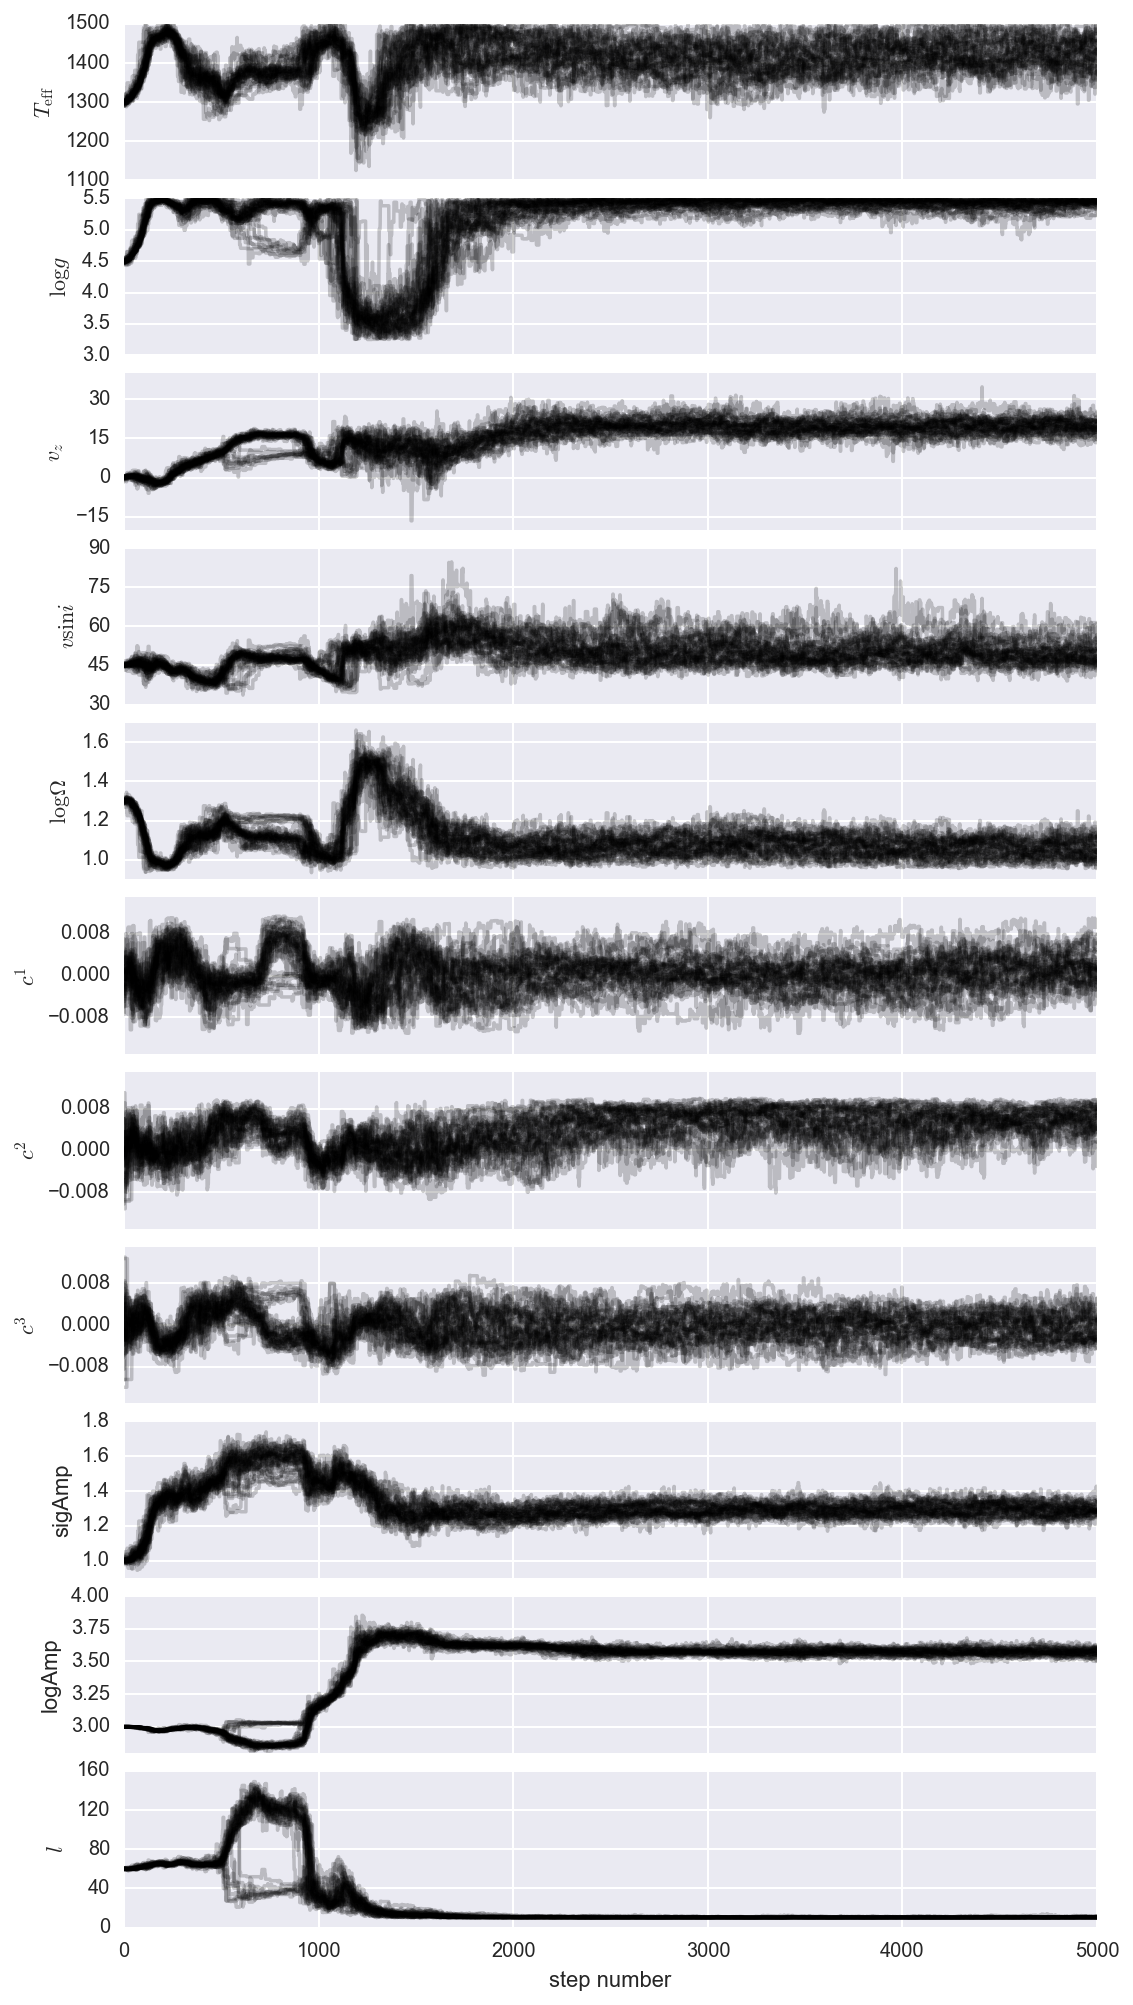

In [6]:
fig, axes = plt.subplots(11, 1, sharex=True, figsize=(8, 14))
for i in range(0, 11, 1):
    axes[i].plot(ws[:, :, i].T, color="k", alpha=0.2)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].set_ylabel(label[i])

axes[10].set_xlabel("step number")
fig.tight_layout(h_pad=0.0)

The last 1000 pixels seem to be adequately burned in.

## Examine the spectral models

In [7]:
ff = h5py.File('../data/IGRINS/reduced/2M0136+0933_m118.hdf5', 'r')
wl, fl, sig = ff['wls'].value, ff['fls'].value, ff['sigmas'].value
ff.close()

In [8]:
dat1 = pd.read_csv('../sf/2M0136/m118/output/marley_grid/run01/spec_config.csv')
dat2 = pd.read_csv('../sf/2M0136/m118/output/marley_grid/run01/models_draw.csv')

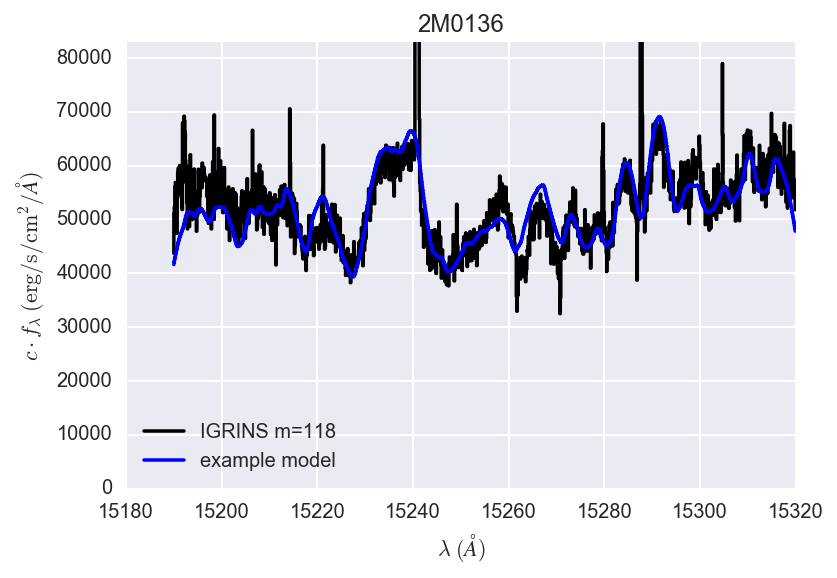

In [10]:
plt.step(dat1.wl, dat1.data, 'k', label='IGRINS m=118')
plt.step(dat1.wl, dat2.model_comp50, 'b', label='example model')
#plt.step(dat1.wl, dat1.model_composite, 'r',label='First Guess')
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('$c\cdot f_\lambda \;(\mathrm{erg/s/cm}^2/\AA)$ ')
plt.title('2M0136')
plt.legend(loc='best')
plt.ylim(0, 1.3*np.percentile(dat1.data, 95))
plt.yscale('linear')
plt.savefig('../results/2M0136_m118_sf.png', dpi=300)

In [24]:
from scipy.stats import multivariate_normal

In [25]:
CC = np.load('../sf/2M0136/m118/output/marley_grid/run01/CC_new.npy')

In [33]:
CC_diag = np.diagflat(CC.diagonal())
CC_orig = np.diagflat(sig**2)

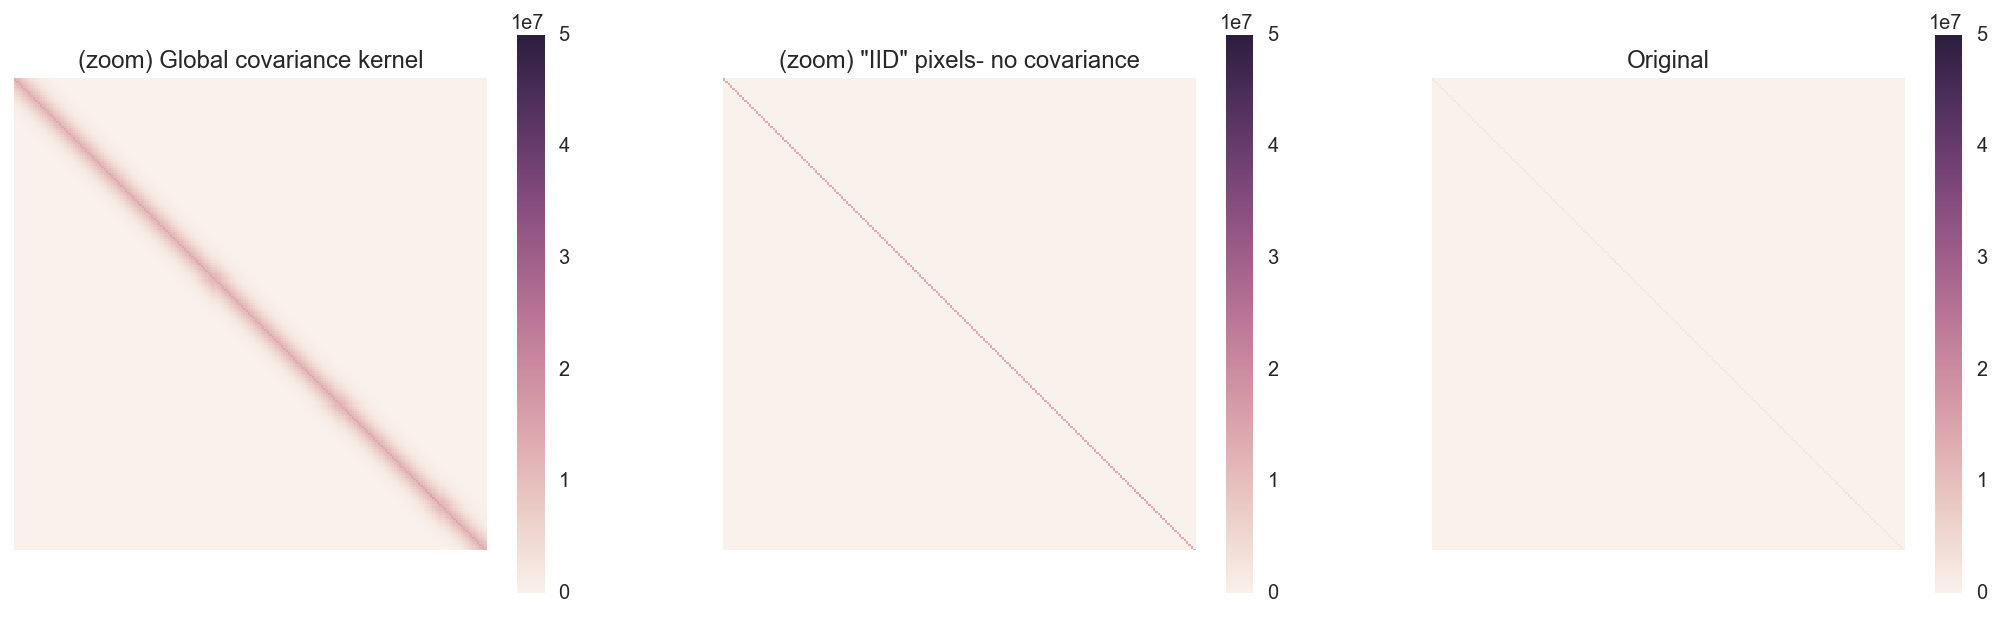

In [34]:
plt.figure(figsize=(18, 5))
plt.subplot(131)
sns.heatmap(CC[600:800, 600:800], xticklabels=False, yticklabels=False, vmax=5.0e7, square=True)
plt.title('(zoom) Global covariance kernel')
plt.subplot(132)
sns.heatmap(CC_diag[600:800, 600:800], xticklabels=False, yticklabels=False, vmax=5.0e7, square=True)
plt.title('(zoom) "IID" pixels- no covariance')
plt.subplot(133)
sns.heatmap(CC_orig[600:800, 600:800], xticklabels=False, yticklabels=False, vmax=5.0e7, square=True)
plt.title('Original')

It looks like the strength of the covariance kernels is large, possibly *too* large?  
The poor fit seems to be demanding a higher average uncertainty.    
It's not clear if this high level is justified.  Let's look at draws from the noise model.

(0, 5000.0)

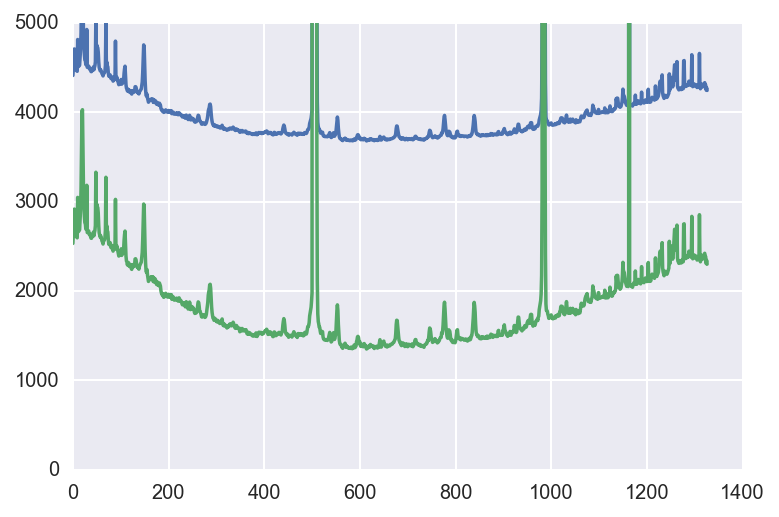

In [35]:
plt.plot(np.sqrt(CC.diagonal()))
plt.plot(sig)
plt.ylim(0, 5.0e3)

The fit wants almost *twice* the uncertainty than what was reported as the $S/N$.

In [38]:
nz_draw = multivariate_normal(dat2.model_comp50, CC)
nz_draw_d = multivariate_normal(dat2.model_comp50, CC_diag)
nz_draw_o = multivariate_normal(dat2.model_comp50, CC_orig)

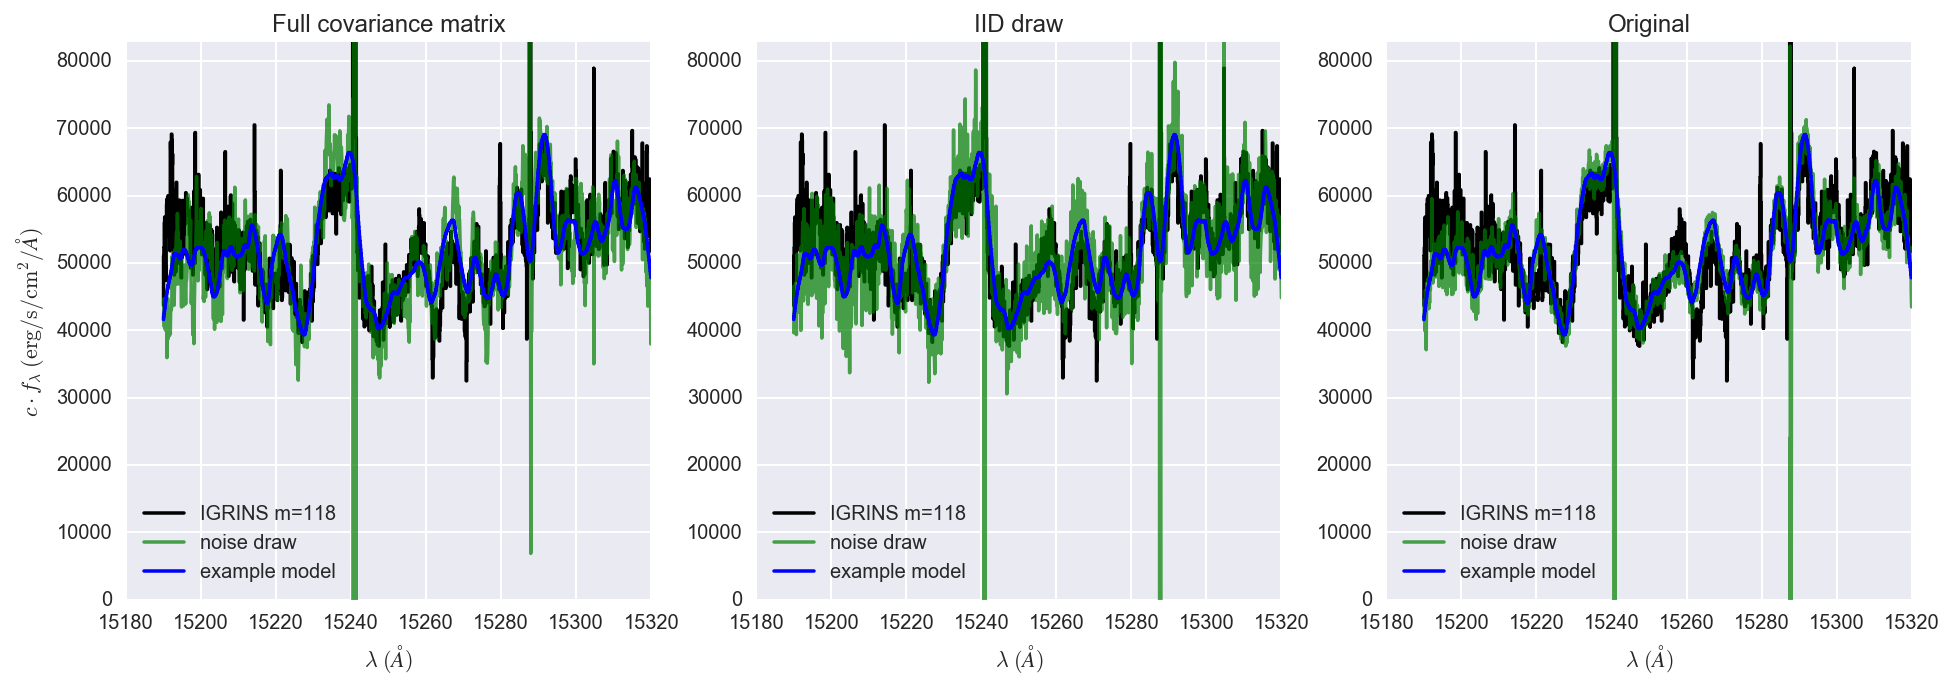

In [40]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.step(dat1.wl, dat1.data, 'k', label='IGRINS m=118')
plt.plot(dat1.wl, nz_draw.rvs(), 'g-', alpha=0.7, label='noise draw')
plt.step(dat1.wl, dat2.model_comp50, 'b', label='example model')

plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('$c\cdot f_\lambda \;(\mathrm{erg/s/cm}^2/\AA)$ ')
plt.title('Full covariance matrix')
plt.legend(loc='best')
plt.ylim(0, 1.3*np.percentile(dat1.data, 95))

plt.subplot(132)
plt.step(dat1.wl, dat1.data, 'k', label='IGRINS m=118')
plt.plot(dat1.wl, nz_draw_d.rvs(), 'g-', alpha=0.7, label='noise draw')
plt.step(dat1.wl, dat2.model_comp50, 'b', label='example model')

plt.xlabel('$\lambda \;(\AA)$')
plt.title('IID draw')
plt.legend(loc='best')
plt.ylim(0, 1.3*np.percentile(dat1.data, 95))

plt.subplot(133)
plt.step(dat1.wl, dat1.data, 'k', label='IGRINS m=118')
plt.plot(dat1.wl, nz_draw_o.rvs(), 'g-', alpha=0.7, label='noise draw')
plt.step(dat1.wl, dat2.model_comp50, 'b', label='example model')

plt.xlabel('$\lambda \;(\AA)$')
plt.title('Original')
plt.legend(loc='best')
plt.ylim(0, 1.3*np.percentile(dat1.data, 95))

plt.yscale('linear')

In [43]:
nz_draw = multivariate_normal(dat2.model_comp50*0.0, CC)
nz_draw_d = multivariate_normal(dat2.model_comp50*0.0, CC_diag)
nz_draw_o = multivariate_normal(dat2.model_comp50*0.0, CC_orig)

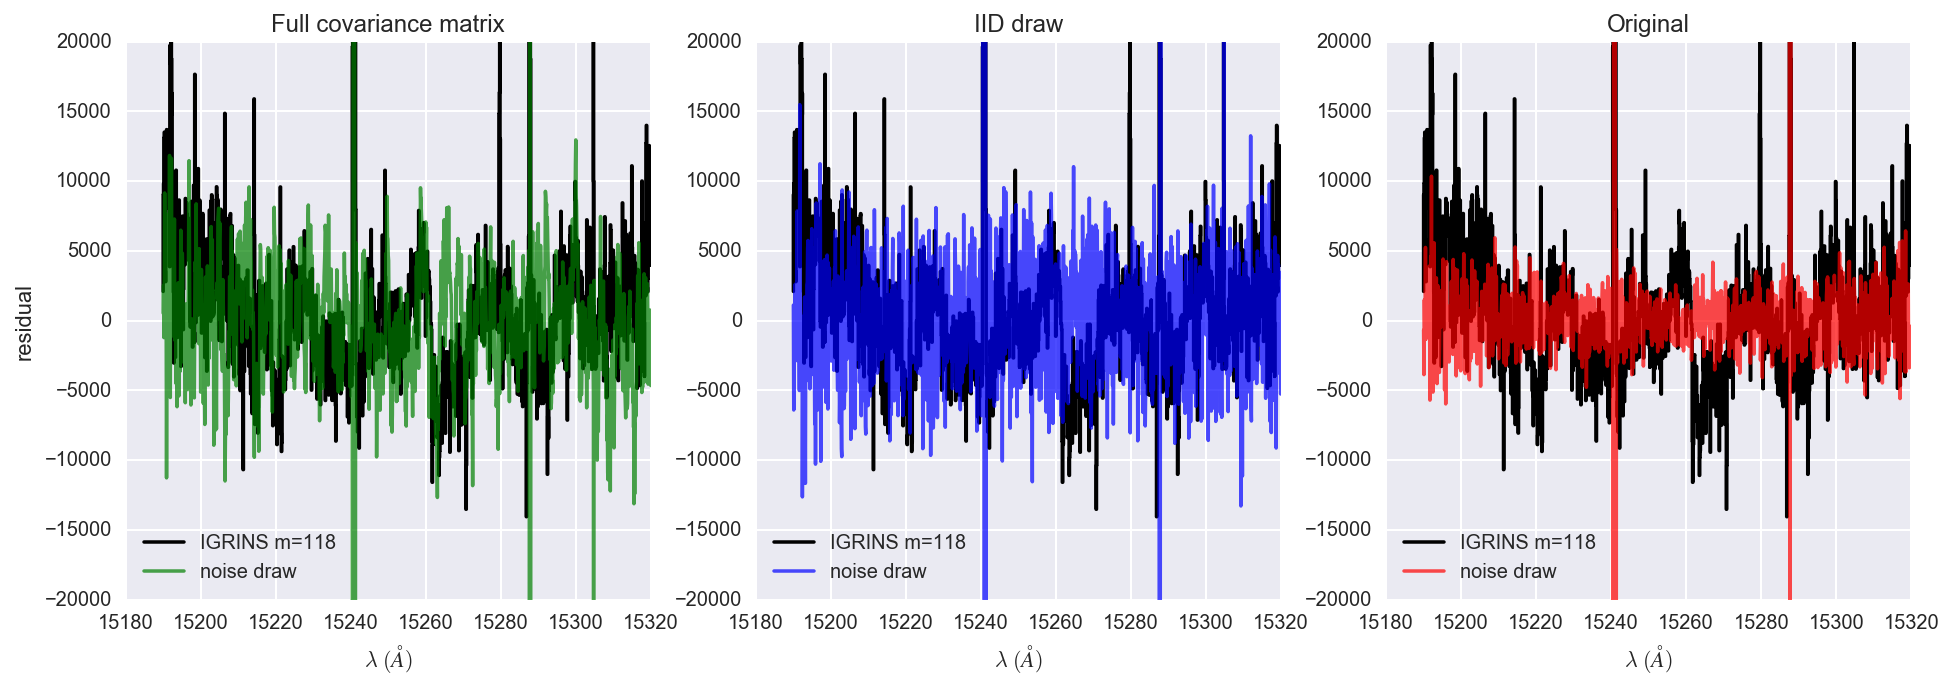

In [87]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.step(dat1.wl, dat1.data-dat2.model_comp50, 'k', label='IGRINS m=118')
plt.plot(dat1.wl, nz_draw.rvs(), 'g-', alpha=0.7, label='noise draw')

plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('residual')
plt.title('Full covariance matrix')
plt.legend(loc='best')
plt.ylim(-20000, 20000)

plt.subplot(132)
plt.step(dat1.wl, dat1.data-dat2.model_comp50, 'k', label='IGRINS m=118')
plt.plot(dat1.wl, nz_draw_d.rvs(), 'b-', alpha=0.7, label='noise draw')

plt.xlabel('$\lambda \;(\AA)$')
plt.title('IID draw')
plt.legend(loc='best')
plt.ylim(-20000, 20000)

plt.subplot(133)
plt.step(dat1.wl, dat1.data-dat2.model_comp50, 'k', label='IGRINS m=118')
plt.plot(dat1.wl, nz_draw_o.rvs(), 'r-', alpha=0.7, label='noise draw')

plt.xlabel('$\lambda \;(\AA)$')
plt.title('Original')
plt.legend(loc='best')
plt.ylim(-20000, 20000)

plt.yscale('linear')

In [63]:
resid = dat1.data-dat2.model_comp50

(0, 350)

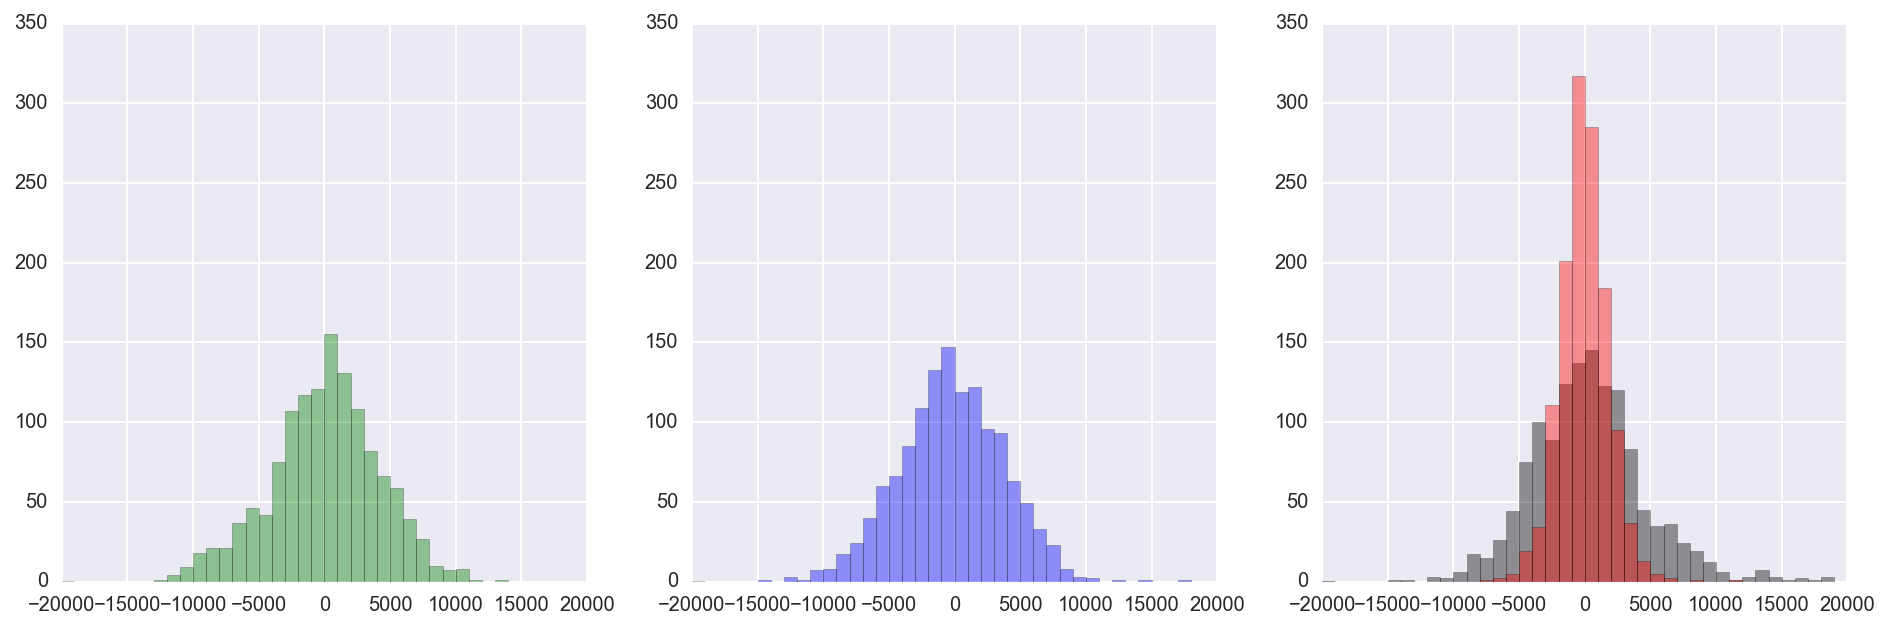

In [96]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
sns.distplot(nz_draw.rvs(), bins=np.arange(-20000, 20000, 1000), color='g', kde=False)
plt.ylim(0, 350)
plt.subplot(132)
sns.distplot(nz_draw_d.rvs(), bins=np.arange(-20000, 20000, 1000), color='b', kde=False)
plt.ylim(0, 350)
plt.subplot(133)
sns.distplot(resid, bins=np.arange(-20000, 20000, 1000), color='k', kde=False)
sns.distplot(nz_draw_o.rvs(), bins=np.arange(-20000, 20000, 1000), color='r', kde=False)
plt.ylim(0, 350)

In [62]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(-50000000000.0, 50000000000.0)

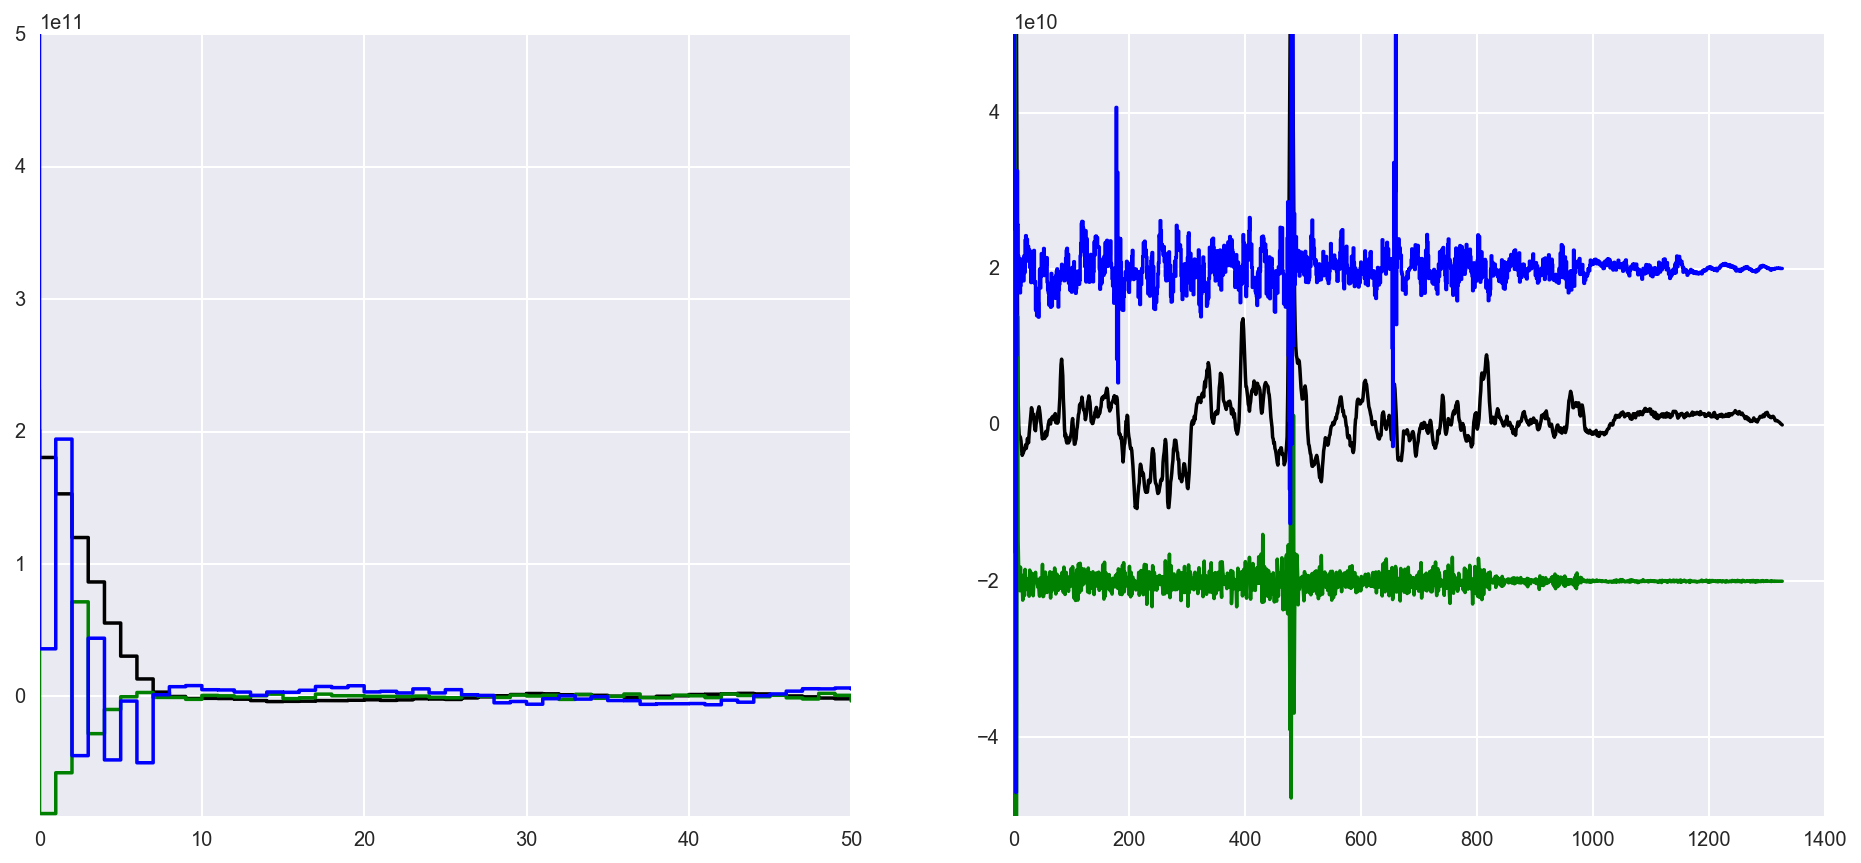

In [92]:
plt.figure(figsize=(16, 7))
plt.subplot(121)
plt.step(autocorr(resid), 'k')
plt.step(autocorr(nz_draw_o.rvs()), 'g')
#plt.step(autocorr(nz_draw_d.rvs()), 'r')
plt.step(autocorr(nz_draw.rvs()), 'b')
plt.xlim(0, 50)
plt.ylim(-9e10, 5e11)

plt.subplot(122)
plt.plot(autocorr(resid), 'k')
plt.plot(autocorr(nz_draw_o.rvs())-2e10, 'g')
#plt.step(autocorr(nz_draw_d.rvs()), 'r')
plt.step(2e10+autocorr(nz_draw.rvs()), 'b')
plt.ylim(-5e10, 5e10)

In [10]:
import corner

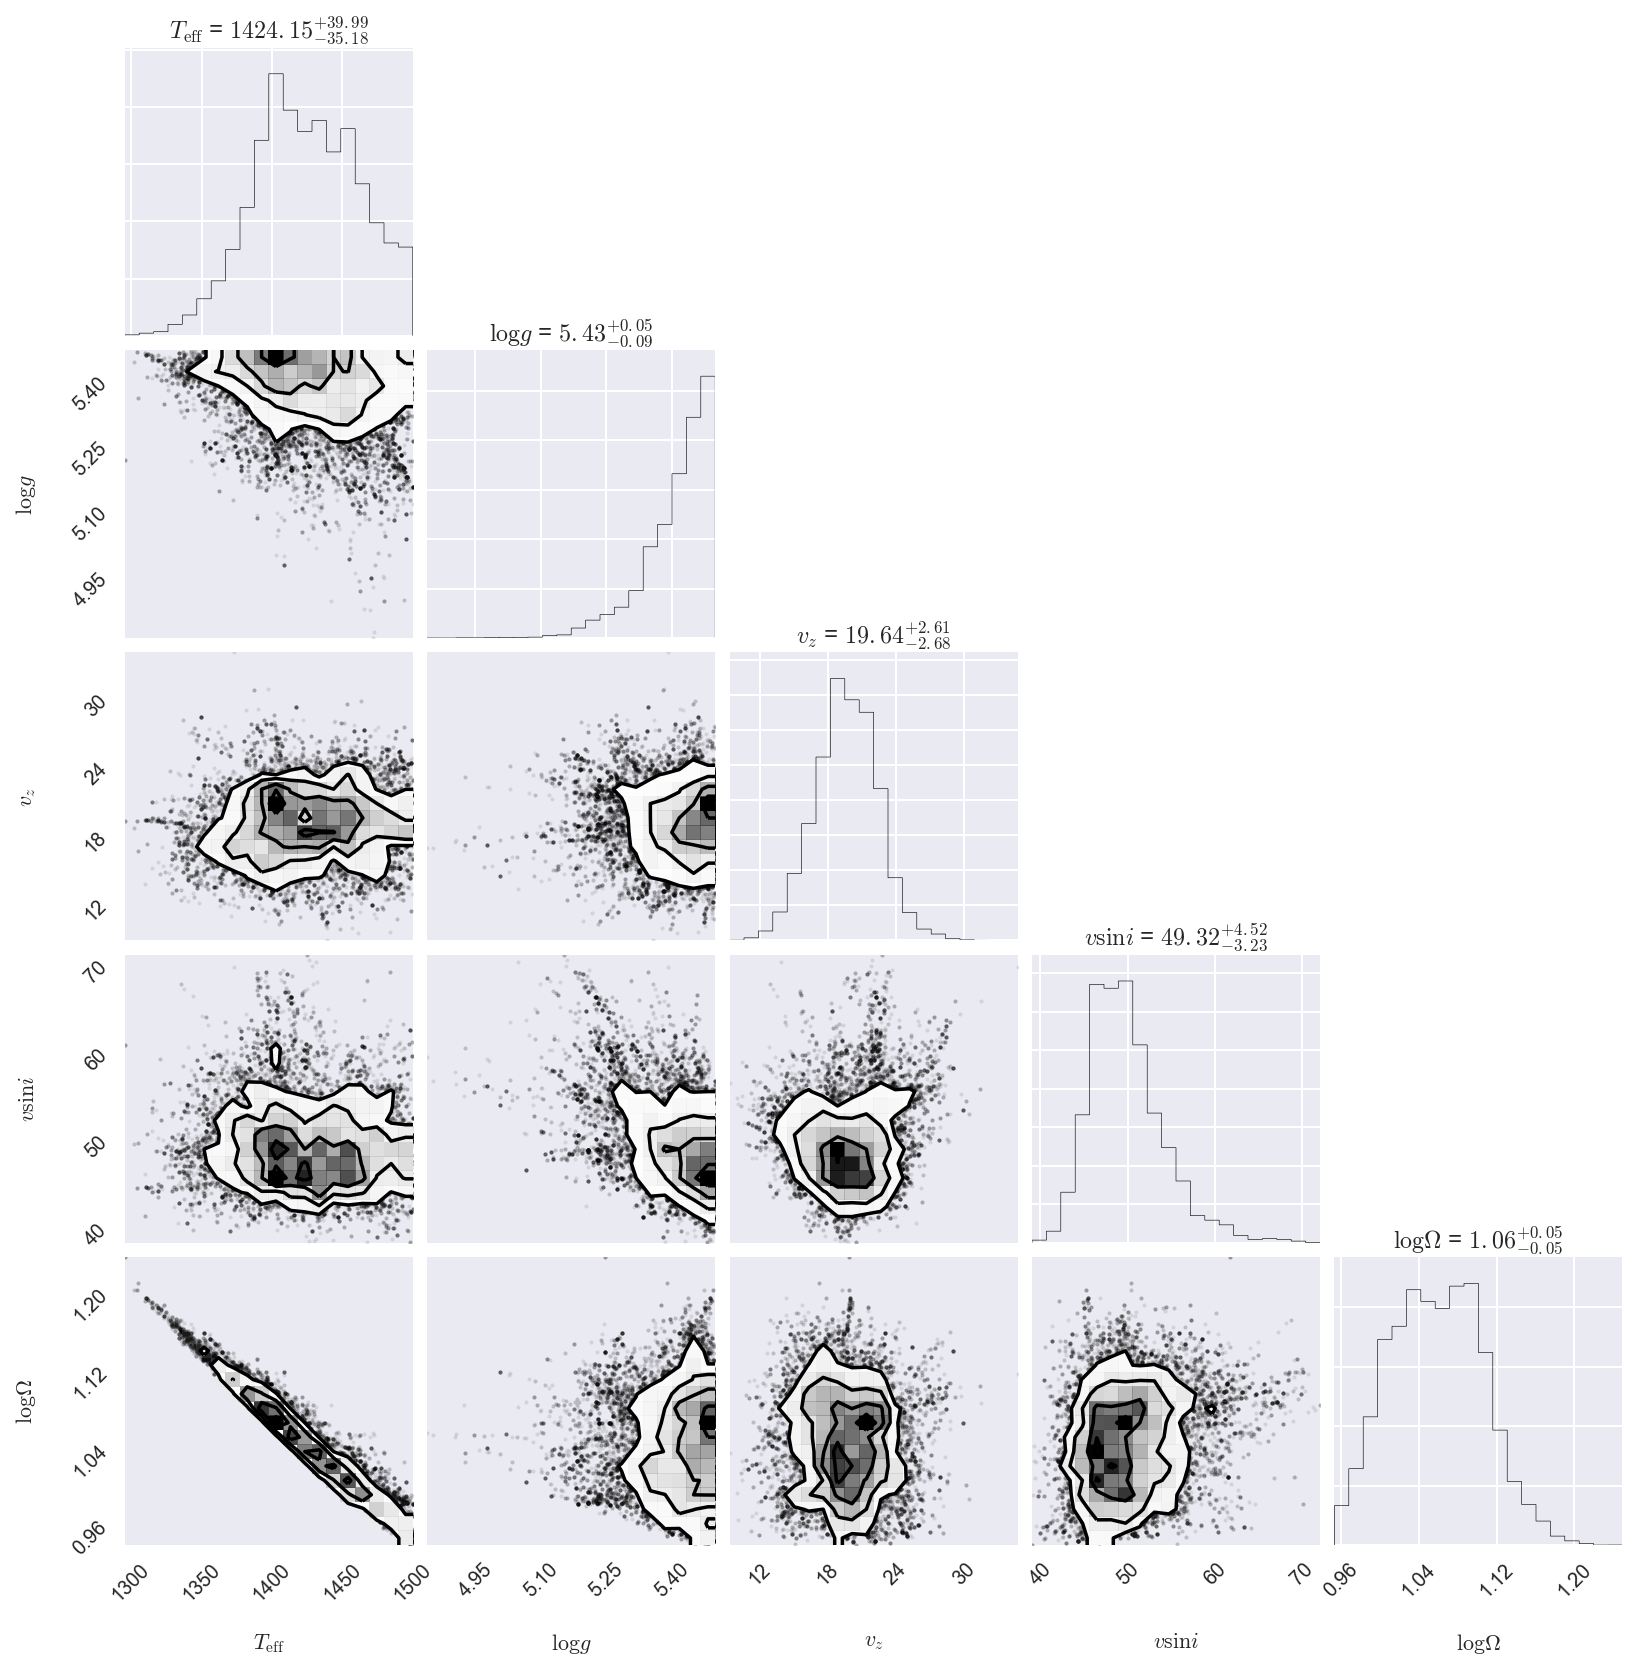

In [11]:
fig = corner.corner(fc[:, 0:5], labels=label[0:5], show_titles=True)
fig.savefig('../results/2M0136_m118_corner.png', dpi=300)

Temperature and solid angle should be strongly degenerate now-- we have *intentionally* added back the absolute flux scaling (basically $\propto \sigma T^4$) that was removed in the `Starfish Classic` mode.  We might consider getting rid of the absolute flux scaling if this turns out to be an issue.  The `emcee` sampler seems to handle the strong degeneracy just fine.

The model likes warm temperatures and high (the highest possible) surface gravity.  I recall Mark Marley predicted this from a physical chemistry perspective.

The end.